In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from scipy import stats
from sklearn.metrics import r2_score

from func2graph import data, models, tools, baselines

In [3]:
KK_GT = np.load('../../data/Mouse_Local_Connectivity/GT_strength_connectivity.npy')
max_abs = np.max(np.abs(KK_GT))
vmin_KK = -max_abs
vmax_KK = max_abs

In [27]:
neuron_num = 200   #####################
tau = 1   ##################### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

init_scale = 1   #####################
weight_scale = 1  #####################
error_scale = 3.5   #####################

total_time = 30000
data_random_seed=42 ######################
weight_type="cell_type"

# window_size = 200
predict_window_size = 1
batch_size = 32
task_type = 'GLM_sim_exp' # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! GLM_sim_tanh, GLM_sim_exp, GLM_sim_none
data_type = 'wuwei'
spatial_partial_measurement = 200

data_result = data.generate_simulation_data(
    neuron_num=neuron_num,
    tau=tau,
    weight_scale=weight_scale,
    init_scale=init_scale,
    error_scale=error_scale,
    total_time=total_time,
    data_random_seed=data_random_seed,
    weight_type=weight_type,
    batch_size=batch_size,
    task_type=task_type,
    predict_window_size=predict_window_size,
    data_type=data_type,
    spatial_partial_measurement=spatial_partial_measurement,
)

# cell_type_ids records the cell type of each neuron
trainloader, validloader, weight_matrix, cell_type_ids, cell_type_order, cell_type_count = data_result
weight_matrix = weight_matrix.detach().numpy()

max_abs = np.max(np.abs(weight_matrix))
vmin_NN = -max_abs
vmax_NN = max_abs

min_val_now:  tensor(0.) tensor(0.) tensor(1.3422) tensor(1.3422)
max_val_now:  tensor(35.8510) tensor(35.8510) tensor(37.1252) tensor(37.1252)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 188/188 [00:00<00:00, 660.15it/s]


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  2662           	|  1.6765         	

(5999, 200) (5999, 200)


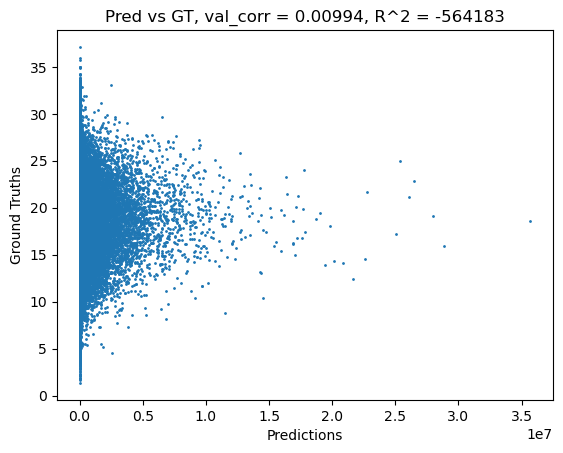

MSE 73856327680.0
unflattened R^2 -5653230054.510837


In [28]:
model_checkpoint_path = "../../output/Baselines_neuroAI/GLMexp_sim.ckpt"   #####################

trained_model = baselines.GLM_sim.load_from_checkpoint(model_checkpoint_path)
trained_model.eval()

trainer = pl.Trainer(
    devices=[0],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)
val_results = trainer.predict(trained_model, dataloaders=[validloader])
val_results = torch.cat(val_results, dim=0).cpu().numpy()   # (N * (2 * neuron_num))

predictions = val_results[:, :neuron_num]
ground_truths = val_results[:, neuron_num:]
print(predictions.shape, ground_truths.shape)

pred_corr = stats.pearsonr(predictions.flatten(), ground_truths.flatten())[0]
R_squared = r2_score(ground_truths.flatten(), predictions.flatten())

plt.scatter(predictions.flatten(), ground_truths.flatten(), s=1)
plt.title("Pred vs GT, val_corr = " + str(pred_corr)[:7] + ", R^2 = " + str(R_squared)[:7])
plt.xlabel("Predictions")
plt.ylabel("Ground Truths")
plt.show()

print('MSE', F.mse_loss(torch.tensor(predictions), torch.tensor(ground_truths)).item())

print('unflattened R^2', r2_score(ground_truths, predictions, multioutput='variance_weighted'))

### W

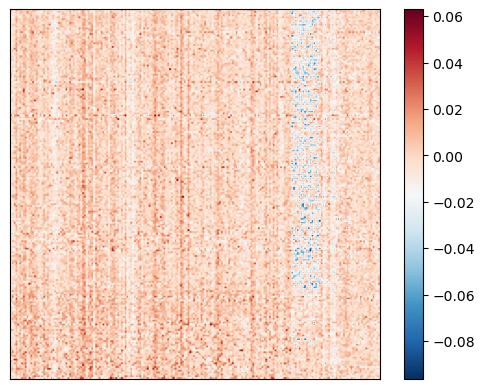

corr 0.5643443956629284


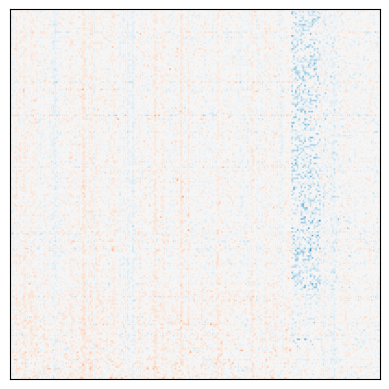

In [29]:
W = trained_model.W.weight.data.detach().cpu().numpy()

plt.imshow(W, cmap='RdBu_r')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

print('corr', np.corrcoef(W.flatten(), weight_matrix.flatten())[0, 1])

transformed_W = tools.linear_transform(W, weight_matrix)
plt.imshow(transformed_W, cmap='RdBu_r', vmin=vmin_NN, vmax=vmax_NN)
plt.xticks([])
plt.yticks([])
plt.show()

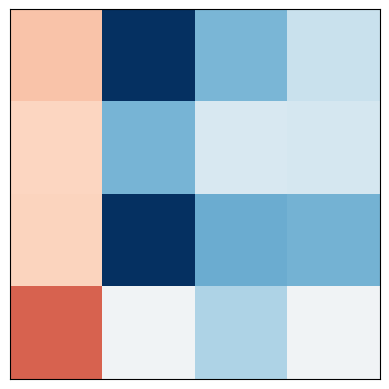

In [30]:
cell_type_id2cell_type = {0:'EC', 1:'Pvalb', 2:'Sst', 3:'Vip'}
KK_strength = tools.calculate_cell_type_level_connectivity_matrix_remove_no_connection(
    connectivity_matrix_new=W,
    connectivity_matrix_GT=weight_matrix, 
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)

transformed_KK_strength = tools.linear_transform(KK_strength, KK_GT)

plt.imshow(transformed_KK_strength, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.show()